## **Imports**

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from google.colab import drive
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import random
import sys
import os


In [47]:
# mount drive folder and import custom modules
drive.mount('/content/drive', force_remount=False)
sys.path.insert(0,'/content/drive/MyDrive/Shark_Classification')

from architectures.smallvggnet import SmallVGGNet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Function to List Files in Directory**

In [48]:
file_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
keep_labels     = ['great_white_shark','hammerhead_shark','whale_shark']

def list_files(indir=os.getcwd(),valid_extensions=file_extensions,valid_labels=keep_labels):
    for (rootdir,dirs,files) in os.walk(indir):
        for filename in files:
            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()
            
            # check to see if the file is an image and should be processed
            if valid_extensions is None or ext.endswith(valid_extensions):
                
                # construct the path to the image and yield it
                imagePath = os.path.join(rootdir, filename)
                
                # yield the path if the label should not be dropped 
                if imagePath.split(os.path.sep)[-2] in valid_labels:
                    yield imagePath
            
    return

## **Read Files**

In [49]:
dataset_path = os.path.join(sys.path[0],'sharks')
output_path= os.path.join(sys.path[0],"output")
    
#obtain image paths and ramdomize it
image_paths = list(list_files(dataset_path))
random.seed(42)
random.shuffle(image_paths)
    
# initialize data and labels list
data, labels, count, max_count = [],[],0,-1

print("[INFO] Reading images from disk. This may take a while ... ")    
for i in image_paths:

    # load the image  and store the image in the data list
    image = cv2.imread(i)
    image = cv2.resize(image, (224, 224))
    data.append(image)
       
    label = i.split(os.path.sep)[-2]
    labels.append(label)
        
    count+=1
    if count==max_count: break

# print label count
label_list = os.listdir(dataset_path)
for l in label_list: print("label: {} counts: {}".format(l,labels.count(l)))

[INFO] Reading images from disk. This may take a while ... 
label: great_white_shark counts: 928
label: mako counts: 0
label: tiger_shark counts: 0
label: hammerhead_shark counts: 744
label: whale_shark counts: 551


## **Data Preprocessing**

### **Train/Test Split**

In [50]:
# convert to np arrays
# image generator .flow method
# doesnt like lists
data = np.array(data,dtype="float")
labels = np.array(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

###**One Hot-Encoding**

In [51]:
original_classes = trainY
    
# integer encode
label_encoder = LabelEncoder()
trainY = label_encoder.fit_transform(trainY)
testY  = label_encoder.transform(testY)
    
#print(original_classes[0:10])
#print(trainY[0:10])
u, indices =np.unique(trainY,return_index=True)
classes = [original_classes[i] for i in indices]
#print(classes)
  
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
trainY = trainY.reshape(len(trainY), 1)
trainY = onehot_encoder.fit_transform(trainY)
testY = testY.reshape(len(testY), 1)
testY = onehot_encoder.transform(testY)
#print(trainY[0:10])

###**Data Augmentation**

In [52]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
  rotation_range=30,
  zoom_range=0.15,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.15,
  horizontal_flip=True,
  fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

##**Define Model and Compile**

In [53]:
# initialize our initial learning rate and # of epochs to train for
INIT_LR = 1e-4
EPOCHS = 50
BS = 32


# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(classes), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

#compiling the model
print("[INFO] compiling model...")
opt = SGD(learning_rate=INIT_LR, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


##**Train Model**

### **Callbacks**

In [61]:
# define early stopping callback
callback= EarlyStopping(
          monitor="val_loss",
          patience=10,
          mode="auto",
          restore_best_weights=True,
          )

### **Warmup**

In [55]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
  layer.trainable = False

# train the network
H = model.fit(x=trainAug.flow(trainX, trainY, batch_size=BS),
              validation_data=valAug.flow(testX, testY, batch_size=BS), 
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS,
              callbacks = [callback])

Epoch 1/50
52/52 [==============================] - 69s 533ms/step - loss: 1.9833 - accuracy: 0.3829 - val_loss: 1.0848 - val_accuracy: 0.3579
Epoch 2/50
52/52 [==============================] - 23s 442ms/step - loss: 1.0563 - accuracy: 0.4593 - val_loss: 1.0465 - val_accuracy: 0.4856
Epoch 3/50
52/52 [==============================] - 23s 444ms/step - loss: 1.0319 - accuracy: 0.4709 - val_loss: 1.0017 - val_accuracy: 0.5144
Epoch 4/50
52/52 [==============================] - 23s 446ms/step - loss: 1.0165 - accuracy: 0.5040 - val_loss: 0.9801 - val_accuracy: 0.5198
Epoch 5/50
52/52 [==============================] - 23s 446ms/step - loss: 0.9950 - accuracy: 0.5101 - val_loss: 0.9935 - val_accuracy: 0.5108
Epoch 6/50
52/52 [==============================] - 24s 447ms/step - loss: 0.9705 - accuracy: 0.5325 - val_loss: 0.9360 - val_accuracy: 0.5917
Epoch 7/50
52/52 [==============================] - 24s 449ms/step - loss: 0.9401 - accuracy: 0.5584 - val_loss: 0.9106 - val_accuracy: 0.5917

### **Fine Tune CNN**

In [64]:
# reset our data generators
#trainAug.reset()
#valAug.reset()

# unfreez las layers
for layer in baseModel.layers[15:]:
  layer.trainable = True

# for the changes to the model to take affect we need to recompile
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=INIT_LR, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the network
H = model.fit(x=trainAug.flow(trainX, trainY, batch_size=BS),
              validation_data=valAug.flow(testX, testY, batch_size=BS), 
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS,
              callbacks = [callback])

[INFO] re-compiling model...
Epoch 1/50
52/52 [==============================] - 19s 359ms/step - loss: 0.0123 - accuracy: 0.9951 - val_loss: 0.1125 - val_accuracy: 0.9784
Epoch 2/50
52/52 [==============================] - 19s 359ms/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 0.1281 - val_accuracy: 0.9766
Epoch 3/50
52/52 [==============================] - 19s 359ms/step - loss: 0.0104 - accuracy: 0.9957 - val_loss: 0.1095 - val_accuracy: 0.9784
Epoch 4/50
52/52 [==============================] - 18s 353ms/step - loss: 0.0187 - accuracy: 0.9951 - val_loss: 0.1147 - val_accuracy: 0.9766
Epoch 5/50
52/52 [==============================] - 19s 355ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.1194 - val_accuracy: 0.9766
Epoch 6/50
52/52 [==============================] - 18s 353ms/step - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.1128 - val_accuracy: 0.9766
Epoch 7/50
52/52 [==============================] - 19s 356ms/step - loss: 0.0110 - accuracy: 0.9957 - val_loss: 

##**Evaluate the Network**

[INFO] evaluating network...
                   precision    recall  f1-score   support

great_white_shark       0.98      0.97      0.98       231
 hammerhead_shark       0.99      0.98      0.98       189
      whale_shark       0.96      0.99      0.97       136

         accuracy                           0.98       556
        macro avg       0.98      0.98      0.98       556
     weighted avg       0.98      0.98      0.98       556



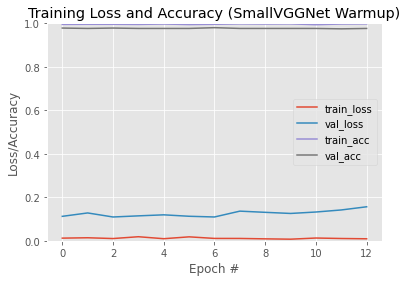

In [65]:
import matplotlib
matplotlib.use("Agg")

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=classes))
#print(confusion_matrix(testY.argmax(axis=1),predictions.argmax(axis=1), labels=classes))
    
# plot the training loss and accuracy
N = np.arange(0, len(H.history["loss"]))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (SmallVGGNet Warmup)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()
plt.savefig(os.path.join(output_path,'vggnet_warmup_plot.jpg'))

##**Save the Model**

In [60]:
# save the model and label binarizer to disk
save = False
if save:
  print("[INFO] serializing network and label binarizer...")
  model.save(os.path.join(output_path,'vggnet_finetune.model'), save_format="h5")
  f = open(os.path.join(output_path,'vggnet_finetune.pickle'), "wb")
  f.write(pickle.dumps(classes))
  f.close()

[INFO] serializing network and label binarizer...
